In [37]:
import glob
import xarray as xr
import matplotlib.pyplot as plt
import geopandas as gpd
import numpy as np
from shapely.geometry import Point
import contextily as ctx
import pandas as pd

# Open one dataset from SPLASH and SAIL campaigns to get Lat/Long points Data

In [27]:
datelist = ['20230418', '20230419']
DATE_FORMAT_STR = '%Y%m%d'
REMOVE_1M_DATA = False

In [28]:
splash_kps_file_dir = '/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-30_Level2_SPLASH2021-2023/'
all_splash_kps_files = glob.glob(os.path.join(splash_kps_file_dir, '*.nc'))

splash_avp_file_dir = '/Users/elischwat/Development/data/sublimationofsnow/asfs/ASFS-50_Level2_SPLASH2021-2023/'
all_splash_avp_files = glob.glob(os.path.join(splash_avp_file_dir, '*.nc'))

avp_slowsled_file = [os.path.join(splash_avp_file_dir, f) for f in all_splash_avp_files if 'sledseb' in f][0]
kps_slowsled_file = [os.path.join(splash_kps_file_dir, f) for f in all_splash_kps_files if 'sledseb' in f][0]

In [29]:
avp_slowsled_ds = xr.open_dataset(avp_slowsled_file)
kps_slowsled_ds = xr.open_dataset(kps_slowsled_file)

## SAIL - ECOR

In [30]:
sail_m1_b1_file_dir = '/Users/elischwat/Development/data/sublimationofsnow/guc30ecorM1.b1/'
all_sail_m1_b1_files = glob.glob(os.path.join(sail_m1_b1_file_dir, '*.cdf'))
sail_s3_b1_file_dir = '/Users/elischwat/Development/data/sublimationofsnow/guc30ecorS3.b1/'
all_sail_s3_b1_files = glob.glob(os.path.join(sail_s3_b1_file_dir, '*.cdf'))

In [31]:
m1_b1_files = [f for f in all_sail_m1_b1_files for datestr in datelist if datestr in f]
s3_b1_files = [f for f in all_sail_s3_b1_files for datestr in datelist if datestr in f]
m1_b1_ds = xr.open_dataset(m1_b1_files[0])
s3_b1_ds = xr.open_dataset(s3_b1_files[0])

In [33]:
avp_gdf = gpd.GeoDataFrame(geometry = [
    Point(
        np.unique(avp_slowsled_ds['lon'].values)[0],
        np.unique(avp_slowsled_ds['lat'].values)[0],
    )
]).set_crs('EPSG:4326')

got_gdf = gpd.GeoDataFrame(geometry = [
    Point(
        np.unique(m1_b1_ds['lon'].values)[0],
        np.unique(m1_b1_ds['lat'].values)[0],
    )
]).set_crs('EPSG:4326')

kps_gdf = gpd.GeoDataFrame(geometry = [
    Point(
        np.unique(kps_slowsled_ds['lon'].values)[0],
        np.unique(kps_slowsled_ds['lat'].values)[0],
    )
]).set_crs('EPSG:4326')

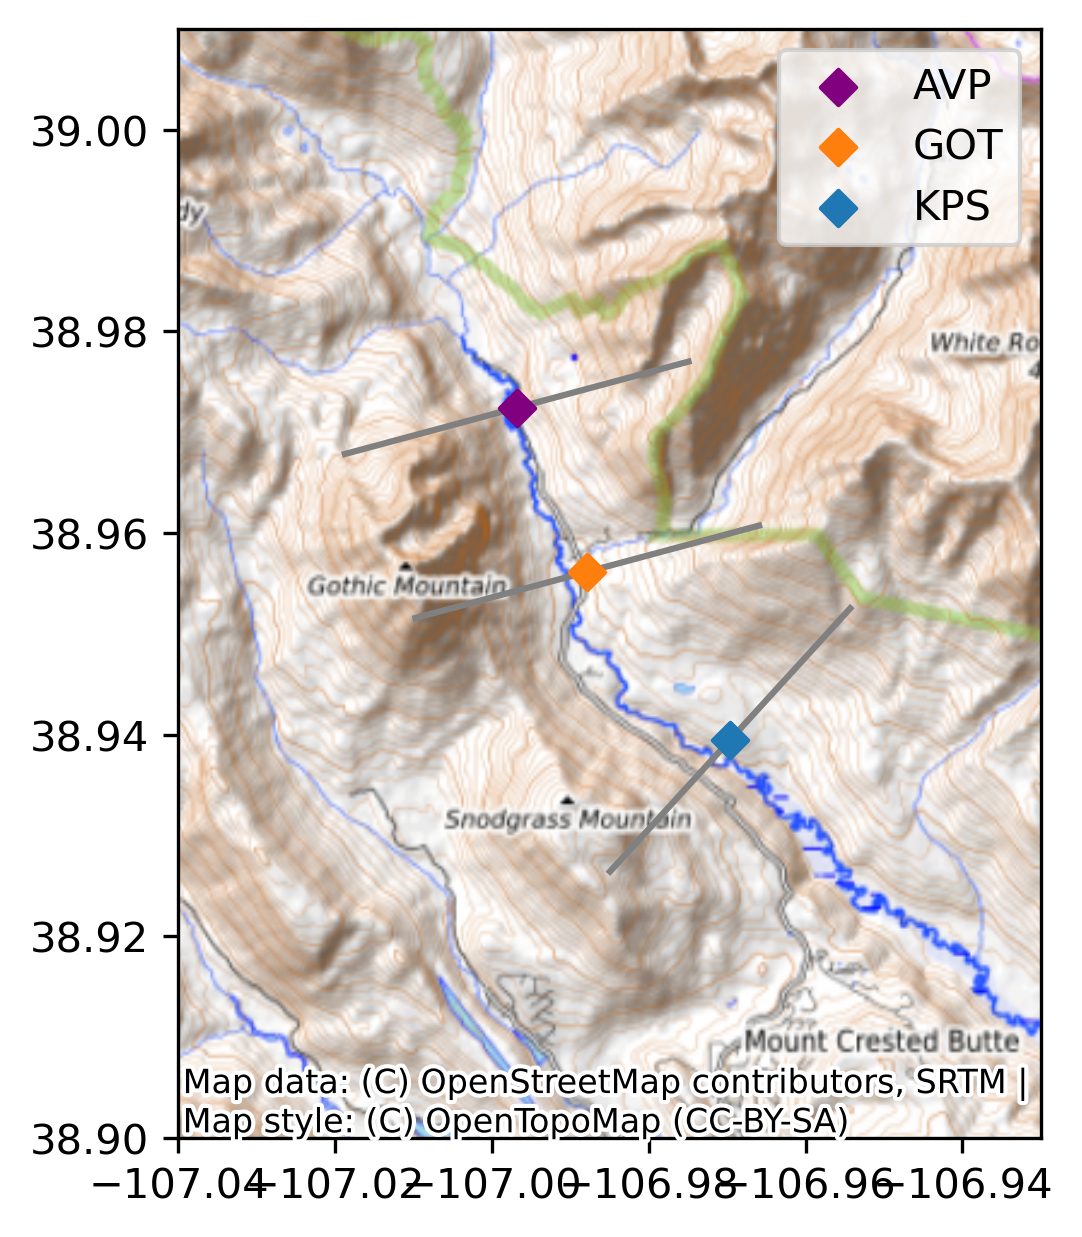

In [270]:
fig, ax = plt.subplots(dpi=300)
sites_gdf.to_crs('EPSG:4326').plot(ax=ax, color='grey', zorder=1)
avp_gdf.plot(marker='D', ax=ax, label='AVP', color='purple',)
got_gdf.plot(marker='D', ax=ax, label='GOT', color='tab:orange')
kps_gdf.plot(marker='D', ax=ax, label='KPS', color='tab:blue')

ax.set_xlim(-107.04, -106.93)
ax.set_ylim(38.90, 39.01)
ctx.add_basemap(ax, zoom=12, source=ctx.providers.OpenTopoMap, crs='EPSG:4326')
plt.legend()



# Get terrain profiles 

In [254]:
sites_gdf = pd.concat([
    avp_gdf.assign(site = 'AVP'),
    got_gdf.assign(site = 'GOT'),
    kps_gdf.assign(site = 'KPS'),
]).set_index('site')
sites_gdf['angle'] = [75, 75, 42.5]
sites_gdf

,geometry,angle
site,,
AVP,POINT (-106.99686 38.97243),75.0
GOT,POINT (-106.98785 38.95616),75.0
KPS,POINT (-106.96963 38.93948),42.5


In [255]:
from sublimpy import extrautils
from shapely.geometry import LineString
import rioxarray as rix
# get lines from the points
sites_gdf['lines'] = sites_gdf.apply(
    lambda row:
    extrautils.get_linestring(row['geometry'].x, row['geometry'].y, row.angle, 2),
    axis=1
)
sites_gdf.geometry = sites_gdf['lines']

# open dem and convert geometry crs to match dem crs
dem = rix.open_rasterio("/Users/elischwat/Development/snow-hydrology/modules/data/east_river_elevation.tif")
sites_gdf = sites_gdf.to_crs(dem.rio.crs)[['geometry']]

/var/folders/x_/2h52bcjx2px15bhmdpdd748h0000gn/T/ipykernel_77956/2189226885.py:11: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  lambda geom: densify_line(geom, resolution) if geom.type == 'LineString' else geom


(4305000.0, 4320000.0)

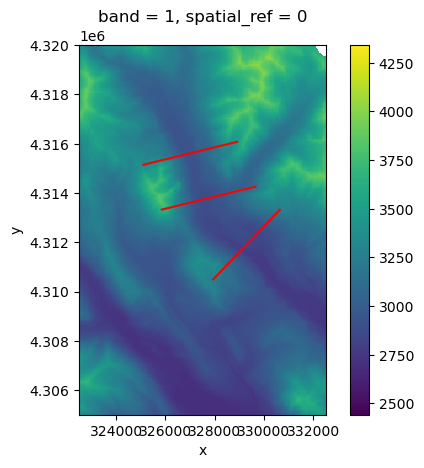

In [256]:
# increase coord density on those lines
def densify_line(line, resolution):
    # Get the cumulative length of the line
    num_points = int(line.length // resolution) + 1
    distances = np.linspace(0, line.length, num_points)
    # Interpolate points along the line
    points = [line.interpolate(distance) for distance in distances]
    return LineString(points)
resolution = 25  # Resolution in meters
sites_gdf['geometry'] = sites_gdf['geometry'].apply(
    lambda geom: densify_line(geom, resolution) if geom.type == 'LineString' else geom
)

fig, ax = plt.subplots()
dem.plot(ax=ax)
sites_gdf.plot(ax=ax, color='red')
plt.xlim(322500, 332500)
plt.ylim(4305000,4320000)

In [257]:
sites_gdf['elev_data'] = sites_gdf.geometry.apply(
    lambda geom: 
    list(pd.Series(list(geom.coords)).apply(
        lambda pt:
        dem.interp(
            x = pt[0],
            y= pt[1],
            method='nearest'
        ).values.item()
    ))
)

In [258]:
avp_elev_series = (pd.Series(sites_gdf['elev_data'].loc['AVP'])).rolling(window=3, center=True).mean()
got_elev_series = (pd.Series(sites_gdf['elev_data'].loc['GOT'])).rolling(window=3, center=True).mean()
kps_elev_series = (pd.Series(sites_gdf['elev_data'].loc['KPS'])).rolling(window=3, center=True).mean()


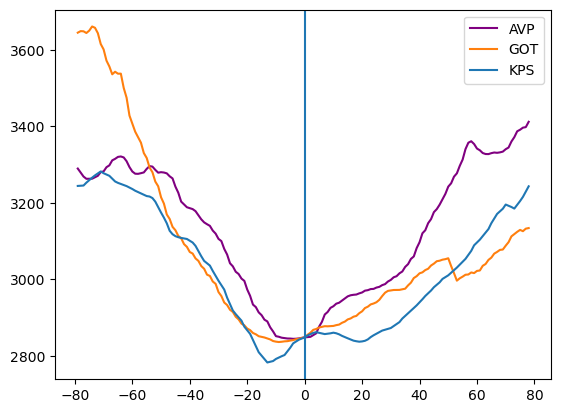

In [259]:
avp_elev_series.index = avp_elev_series.index - 80
got_elev_series.index = got_elev_series.index - 80
kps_elev_series.index = kps_elev_series.index - 80
(avp_elev_series - (avp_elev_series.loc[0] - kps_elev_series.loc[0])).plot(label='AVP', color='purple',)
(got_elev_series - (got_elev_series.loc[0] - kps_elev_series.loc[0])).plot(label='GOT', color='tab:orange')
(kps_elev_series).plot(label='KPS', color='tab:blue')
plt.axvline(0)
plt.legend()
plt.savefig('topo_profiles.svg')

In [ ]:
plt.savefig